In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, Subset
import os
import torchaudio
import numpy as np
import matplotlib.pyplot as plt


from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio

%matplotlib ipympl

# Import des fonctions faites en fichiers
from Techno_Dataset import Create_Dataset
from Spectral_Loss import Spectral_Loss
from Utilities import Reshape

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Dataset


In [4]:
dataset_dir = "./data/TECHNO/techno_resampled.dat"
valid_ratio_ = 0.995
num_threads = 0
batch_size = 32
train_loader,valid_loader = Create_Dataset(dataset_dir = "../../Victor BIGAND/TECHNO/techno_resampled.dat", valid_ratio = valid_ratio_ ,num_threads = 0,batch_size  = 32)

The train set contains 214 samples of length 32768, in 7 batches
The validation set contains 42432 samples of length 32768, in 1326 batches


## Archi VAE Raw Audio

In [5]:
class VAE(nn.Module):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims
        self.encoding_dims = encoding_dims
        self.encoder = encoder
        self.decoder = decoder
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))
        self.log_sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        self.lat_to_enc = nn.Sequential(nn.Linear(self.latent_dims,self.encoding_dims),nn.ReLU()) # To get z from latent_dims to encoding_dims after sampling
        
        
    def encode(self, x):
        
        x = self.encoder(x)
        mu = self.mu(x)
        log_sigma = self.log_sigma(x)
        
        return mu, log_sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(z_params)
        #print(z_tilde.shape)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div
    
    def latent(self, z_params):
        
        mu, log_sigma = z_params
        std = torch.exp(log_sigma)
        eps = torch.rand_like(std)
        z = mu + eps * std
        z = self.lat_to_enc(z)

        
        kl_div = 0.5 * (1 + log_sigma - mu**2 - torch.exp(log_sigma))
        kl_div = torch.mean(kl_div)  #,dim=-1
        

        return z, kl_div

In [6]:
def construct_encoder_decoder(nin=1, encoding_dims = 128, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
        nn.Conv1d(nin, 16, 4, stride=4, padding=0),
        nn.ReLU(),


        nn.Conv1d(16, 32, 4,stride=4,  padding=0), 
        nn.ReLU(),

        nn.Conv1d(32, 64, 4,stride=4,  padding=0), 
        nn.ReLU(),

        nn.Conv1d(64, 128, 4,stride=2,  padding=1), 
        nn.ReLU(),

        #nn.Flatten(1),

        nn.Linear(32768//128, n_hidden),
        nn.ReLU(),

        nn.Linear(n_hidden, encoding_dims)
        )

    # Decoder network
    decoder = nn.Sequential(
    nn.Linear(encoding_dims,n_hidden), 
        nn.ReLU(),

        nn.Linear(n_hidden, 32768//128), 
        nn.ReLU(),

        #nn.Unflatten(1,(128, 32768//128)),

        nn.ConvTranspose1d(128, 64,  4,stride=2,  padding=1), 
        nn.ReLU(),

        nn.ConvTranspose1d(64, 32,  4,stride=4,  padding=0), 
        nn.ReLU(),

        nn.ConvTranspose1d(32, 16, 4,stride=4,  padding=0), 
        nn.ReLU(),

        nn.ConvTranspose1d(16, nin, 4,stride=4,  padding=0),
        nn.Tanh()

        
    )
    return encoder, decoder

In [7]:
# Reconstruction criterion Spectral_Loss
n_fft = 16384
win_lenght = 1024 # Taille fenêtre
window = "Hamming" # Type fenêtre (pour l'instant que Hamming)
epsilon = 1 # Revoir ce que c'est mais important

def compute_loss(model, x,beta = 0.1): 
    y_pred,kl_div = model(x)
    full_loss = Spectral_Loss(y_pred, x,n_fft,win_lenght,window,epsilon) - kl_div*beta
    
    return full_loss

def train_step(model, x, optimizer, beta=0.1):
    model = model#.to(device)
    x = x#.to(device)
    # Compute the loss.
    loss = compute_loss(model, x,beta)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

In [8]:
# Parameters of the train :

# KL_div Factor
beta = 0.1
# Number of hidden and latent
n_hidden = 128
encoding_dims = 64
latent_dims = 32
# Compute input dimensionality
nin = 1
# Using Bernoulli or Multinomial loss
num_classes = 1

In [9]:
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin,encoding_dims,n_hidden,n_classes=num_classes)
encoder = encoder#.to(device)
decoder = decoder#.to(device)
# Build the VAE model
model = VAE(encoder, decoder, encoding_dims, latent_dims)#.to(device)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
checkpoint = 'TECHNO_CONV_BCE_sum_Beta=0.1'
writer = SummaryWriter('runs/' + checkpoint)

configuration = {"batch_size : ": batch_size, "Loss : ": "Spectral_Loss", "Reduction : ": "mean", "Beta : ": 0.1, "Encoding_dims :" : encoding_dims, "Latent_dims : ":latent_dims}

t = ""
for key, val in configuration.items():
    t += "{}  \t{}  \n".format(key, val)
writer.add_text("Configuration", t)

In [11]:
def train_vae(model, epochs,beta = 0.1):
    for epoch in range(1, epochs + 1):
        full_loss = torch.Tensor([0])#.to(device)
        
        # Forward pass: compute predicted y by passing x to the model.
        for i, x in enumerate(train_loader):
            #x=x#.to(device)
            #model=model#.to(device)
            
            full_loss_add= train_step(model, x, optimizer,beta)
            full_loss += full_loss_add

        writer.add_scalar("Loss/Full_Loss", full_loss.cpu().detach().numpy(),epoch)
        writer.flush()
        print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))

In [12]:
epochs = 5

train_vae(model,epochs,beta)

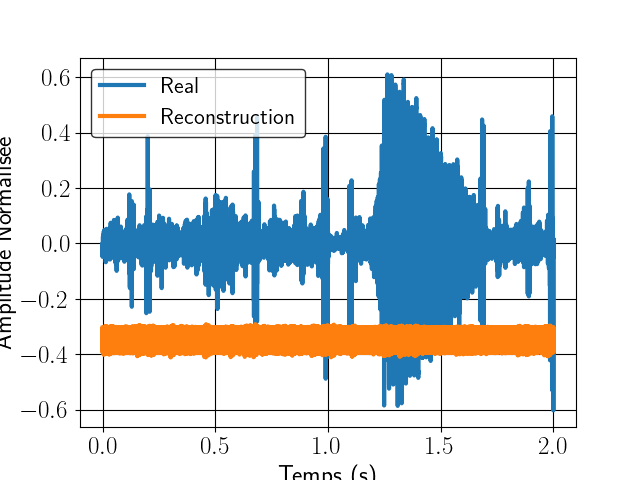

In [ ]:
for i,x in enumerate(train_loader):
    echant_test = x[0]
    
predictions, _ = model(echant_test)

test = predictions[0].detach().numpy()
Fe = len(test)//2
temps = np.arange(len(test))/Fe

plt.figure()
plt.plot(temps,echant_test[0].numpy(),label="Real")
plt.plot(temps,test,label="Reconstruction")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude Normalisée")
plt.grid()
plt.legend()
plt.show()

In [24]:
Audio(echant_test[0],rate = Fe)

In [25]:
Audio(test,rate = Fe)